In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.gridspec as gridspec
import matplotlib.patches as patch
from tqdm import tqdm

# Code for simulation

In [13]:
class Sim2D:
    '''  2D simulation, deterministic'''
    def __init__(self, L = 100, Tmax = 1000, N0 = [], Ts = 0, dt=0.1, model=0, fs=0.05 ):
        self.L = L; # simulation box size
        self.Tmax = Tmax; # maximum timestep
        if(N0==[]): # default construction of initial poppulation density
            N0 = np.zeros((2,L,L)); # spatial population density by (type, x, y)
            N0[0,:int(L/2)-5,:3]+=1; N0[0,int(L/2)+5:,:3]+=1; # initialize wildtype background
            N0[1,int(L/2)-5:int(L/2)+5,:3]+=1; #initialize a narrow mutant slab 
        self.N = N0;
        if(Ts==0): # take snapshots at fixed timesteps
            Ts = np.arange(0,Tmax+1,50);
        self.Ts = Ts;
        self.Ns = np.zeros(( len(Ts), 2, np.shape(N0)[1] , np.shape(N0)[2] )); # spatiotemporal population density
        self.Ns[0] = N0;
        self.T = 0;
        self.Tc = 0;
        self.dt = dt;
        self.Nshift = np.zeros(Tmax);
        self.Model = model;
        self.K = 1;
        self.fs = fs;
        
        
    def generate_step(self, param): #initialize parameters
        self.Param = param;
        if(self.Model == 0): # growth-dispersal tradeoff model
            r, D0, D1, s = param;
            self.r = r; self.D0 = D0; self.D1 = D1; self.s = s; 
        elif(self.Model == 3): # cooperator-cheater model
            r, D, s, a, b = param;
            self.r = r; self.D = D; self.s = s; self.a = a; self.b=b; 
        elif(self.Model == 4): # constant growth / dispersal model
            r, D0, D1, s = param;
            self.r = r; self.D0 = D0; self.D1 = D1; self.s = s; 
            
    def update(self): # models how population grows and disperses in each timestep
        Nl = np.roll(self.N, -1, axis=2); Nl[:,:,-1] = self.N[:,:,-1]; # Nleft[i,j] is the left-element of N[i,j], i.e. Nleft[i,j] = N[i,j+1] 
        Nr = np.roll(self.N, 1, axis=2); Nr[:,:,0] = self.N[:,:,0];
        Nu = np.roll(self.N, 1, axis=1);
        Nd = np.roll(self.N, -1, axis=1);
        
        if(self.Model==0): # growth-dispersal tradeoff model
            M = np.copy(self.N); M[0]+=self.N[1]; M[1]+=self.N[0]; 
            Ds = np.copy(self.N)*0; Ds = Ds + self.D0;
            Ds = np.where(M==0, Ds, Ds-self.D1*self.N/M ); Ds[0]=Ds[1];
            Dl = np.roll(Ds, -1, axis=2); Dl[:,:,-1] = Ds[:,:,-1]; 
            Dr = np.roll(Ds, 1, axis=2); Dr[:,:,0] = Ds[:,:,0];
            Du = np.roll(Ds, 1, axis=1);
            Dd = np.roll(Ds, -1, axis=1);
            dn = (Dl*Nl + Dr*Nr-4*Ds*self.N + Du*Nu + Dd*Nd) + self.r*self.N; dn[1] = dn[1]+self.r*self.s*self.N[1];
            dn = dn*(1-M/self.K);
            
            return dn
        
        elif(self.Model==3): # cooperator-cheater model
            M = np.copy(self.N); M[0]+=self.N[1]; M[1]+=self.N[0]; # total local population
            f = np.where(M==0, 0, self.N/M); 
            ab = np.zeros((2,self.L,self.L)); ab[0]+=self.a; ab[1]+=self.b;
            r = np.zeros((2,self.L,self.L)); r[0]+=self.r; r[1]+=self.r*(1-self.s);
            dn = self.D*(Nl + Nr - 4*self.N + Nu + Nd) + (r + np.flip(f,0)*ab)*self.N;
            dn = dn*(1-M/self.K);
            
            return dn
        
        elif(self.Model==4): # constant growth / dispersal model
            M = np.copy(self.N); M[0]+=self.N[1]; M[1]+=self.N[0]; # total local population
            Ds = np.copy(self.N)*0; 
            Ds = Ds+self.D0; Ds[1] = Ds[1]-self.D1;
            Dl = np.roll(Ds, -1, axis=2); Dl[:,:,-1] = Ds[:,:,-1]; 
            Dr = np.roll(Ds, 1, axis=2); Dr[:,:,0] = Ds[:,:,0];
            Du = np.roll(Ds, 1, axis=1);
            Dd = np.roll(Ds, -1, axis=1);
            dn = (Dl*Nl + Dr*Nr-4*Ds*self.N + Du*Nu + Dd*Nd) + self.r*self.N; dn[1] = dn[1]+self.r*self.s*self.N[1];
            dn = dn*(1-M/self.K);
            
            return dn
        
        
        else:
            print("model not implemented")
    
        
    def proceed(self): # propagate over time
        while(self.T < self.Tmax):
            self.Nshift[self.T] = self.Nshift[self.T-1];
            self.N += self.update()*self.dt;
            self.N = self.N*(self.N > 0);
            
            # shift the co-moving frame if the colony expands far enough
            if(np.sum( self.N[0,:,int(self.L/2)] + self.N[1,:,int(self.L/2)] ) > 0.5*self.L   ):
                self.Nshift[self.T] += int(self.L*self.fs);
                self.N = np.roll(self.N, -int(self.L*self.fs), axis=2); 
                self.N[:,:,int(self.L)-int(self.L*self.fs): ] = 0*self.N[:,:,int(self.L)-int(self.L*self.fs): ];
            # Terminate if the midpoint mutant population is greater than 0.25. (i.e. more than half at shift)
            if( np.sum(self.N[1,:,int(self.L/2)])  > 0.25*self.L   ):
                for i in np.arange(self.Ns.shape[0]-self.Tc):
                    self.Ns[self.Tc+i, :, :, :] = self.N;
                self.T = self.Tmax;
            self.T = self.T + 1;
            # save snapshot in fixed timesteps
            if(self.T in self.Ts):
                self.Ns[self.Tc, :,:,: ] = self.N;
                self.Tc = self.Tc + 1;

In [3]:
class analysis: # visualization tool for simulation result
    def __init__(self, sim):
        self.Ns = sim.Ns;
        self.Ts = sim.Ts;
        self.Nshift = sim.Nshift;
        self.L = np.shape(sim.Ns)[2];
        self.Model = sim.Model;
        self.Param = sim.Param;
        self.dt = sim.dt;
        self.T = sim.T;
        self.K = sim.K;
        self.Tmax = sim.Tmax;
    def snap( self, t=-2 ):
        img = np.zeros((np.shape(self.Ns)[2],np.shape(self.Ns)[3],3));
        img[:,:,0]=self.Ns[t,0]; img[:,:,1]=self.Ns[t,1];
        return plt.imshow( img, interpolation='bilinear' )
    def snapsave( self, t=-2 ):
        img = np.zeros((self.L,self.L,3));
        img[:,:,0] = np.where( self.Ns[t,0]+self.Ns[t,1]<0.5*self.K, 0, self.Ns[t,0]/(self.Ns[t,0]+self.Ns[t,1]) );
        img[:,:,1] = np.where( self.Ns[t,0]+self.Ns[t,1]<0.5*self.K, 0, self.Ns[t,1]/(self.Ns[t,0]+self.Ns[t,1]) );
        return img
    def snaps(self, ts, c=True ):
        fig, ax = plt.subplots( 1, len(ts), figsize= (5*len(ts), 7) );
        for i in np.arange(len(ts)):
            img = np.zeros((np.shape(self.Ns)[2],np.shape(self.Ns)[3],3));
            img[:,:,0] = np.where( self.Ns[ts[i],0]+self.Ns[ts[i],1]<0.5*self.K, 0, self.Ns[ts[i],0]/(self.Ns[ts[i],0]+self.Ns[ts[i],1]) );
            img[:,:,1] = np.where( self.Ns[ts[i],0]+self.Ns[ts[i],1]<0.5*self.K, 0, self.Ns[ts[i],1]/(self.Ns[ts[i],0]+self.Ns[ts[i],1]) );
            #img[:,:,3] = self.Ns[ts[i],0]+self.Ns[ts[i],1];
            if(c):
                CS = ax[i].contour( img[:,:,1] );#
                ax[i].clabel(CS, inline=1, fontsize=10);
            ax[i].imshow(img, interpolation='bilinear');
            ax[i].set_title('t='+str( self.Ts[ts[i]+1]*self.dt)[:4]+'hrs');
        fig.suptitle('Model='+str(self.Model)+', params='+str(self.Param), y=0.85, fontsize=15 );
        return fig, ax

# 210306 Simulations for manuscript

In [4]:
us = np.zeros((3,3));
for i in np.arange(3):
    us[i] = np.array([0.2,0.6,1.]);
vms = np.zeros((3,3));
vms[0] = np.sqrt(1+us[0]**2);
vms[1] = 1+(vms[0]-1)/2;
vms[2] += 0.8;

In [5]:
# model 0: growth-dispersal tradeoff
# model 3: cheater-cooperator
# model 4: density-independent.
imgs = np.load('sim_model0.npz')['imgs']

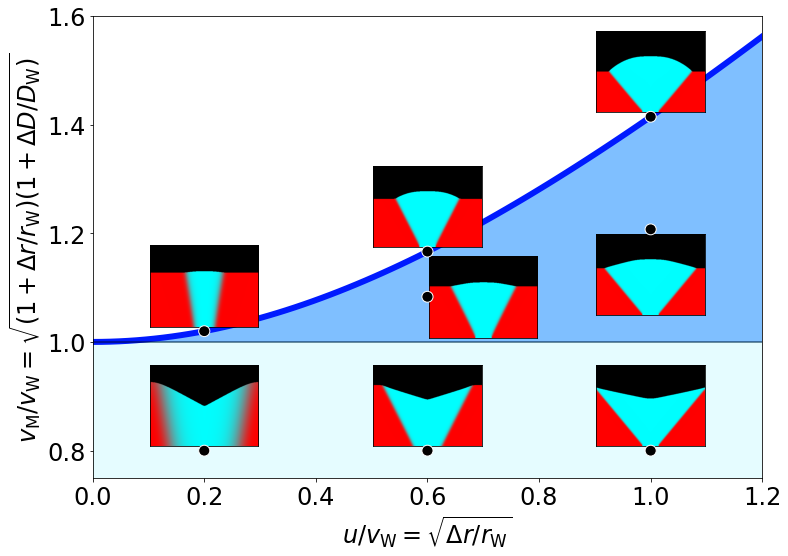

In [15]:
fig, ax = plt.subplots(figsize = (12,8.5) );

xs = np.linspace(0,1.6**2-1,100);
ys1 = np.sqrt(1 + xs**2);
xyf = np.zeros((300,2));
xyf[:100,0]=xs; xyf[:100,1]=ys1;
xyf[100:200,0]=np.flip(xs); xyf[100:200,1]=np.ones(100)*ys1[-1];
xyf[200:,0]=0; xyf[200:,1]=np.flip(ys1);

xy2 = np.zeros((300,2));
xy2[:100,0]=xs; xy2[:100,1]=ys1;
xy2[100:200,0]=np.ones(100)*xs[-1]; xy2[100:200,1]=np.flip(ys1);
xy2[200:,0]=np.flip(xs); xy2[200:,1]=np.ones(100)*1;

ax.add_patch(patch.Polygon(xyf, color=(1.,1.,1.), alpha=0.9) )
ax.add_patch(patch.Polygon(xy2, color=(0,0.5,1.), alpha=0.5) )
ax.add_patch(patch.Rectangle( (0,0.75),1.2,0.25 , color=(0,0.9,1.), alpha=0.1) )
#ax.add_patch(patch.Rectangle( (-0.5,0),0.5,10 , fill=False) )
ax.plot(xs, ys1, color=(0.,0.1,1.0), alpha=1, linewidth=6)
ax.plot(xs, xs*0+1, color='k', alpha=0.5)

for i in np.arange(3):
    for j in np.arange(3):
        x = us[i,j];
        y = vms[i,j];
        if( (i,j)==(1,0) ): continue;
        if(i in [0,2]): 
            x = x-0.1; y = y+0.008; ax.add_patch( patch.Circle( (x+0.1, y-0.008), 0.01, facecolor='k', edgecolor='w', linewidth=1, zorder=10 ) );
        elif((i,j)==(1,1)):
            y = y - 0.075; ax.add_patch( patch.Circle( (x, y+0.075), 0.01, facecolor='k', edgecolor='w', linewidth=1, zorder=10 ) );
        elif((i,j)==(1,2)):
            x = x-0.1; y = y-0.158; ax.add_patch( patch.Circle( (x+0.1, y+0.158), 0.01, facecolor='k', edgecolor='w', linewidth=1, zorder=10 ) );
        else:
            ax.add_patch( patch.Circle( (x, y), 0.01, facecolor='k', edgecolor='w', linewidth=1, zorder=10 ) );
        test = ax.inset_axes([x,y,0.2,0.15], transform=ax.transData);
        img = np.copy(imgs[i,j]);
        img = img.swapaxes(0,1);
        img = np.flip(img,axis=0);
        img = img[100:]
        test.imshow(img);
        test.set_xticks([]);
        test.set_yticks([]);

ax.set_xlim(0.0,1.2);
ax.set_ylim(0.75,1.6);

# model 3
#ax.set_xlabel(r'$u/v_{\rm W}=\sqrt{\alpha-s}$', fontsize=24);
#ax.set_ylabel(r'$v_{\rm M}/v_{\rm W}=\sqrt{ 1-s }  $', fontsize=24);

# model 0
ax.set_xlabel(r'$u/v_{\rm W}=\sqrt{\Delta r / r_{\rm W}}$', fontsize=24);
ax.set_ylabel(r'$v_{\rm M}/v_{\rm W}=\sqrt{ (1+\Delta r/r_{\rm W})(1+\Delta D/D_{\rm W})  }  $', fontsize=24);

ax.set_yticks([0.8, 1., 1.2, 1.4,1.6]);
plt.setp(ax.get_yticklabels(), Fontsize=24);
plt.setp(ax.get_xticklabels(), Fontsize=24);

#fig.savefig('4b.pdf',bbox_inches='tight')

In [7]:
# model 0: growth-dispersal tradeoff
# model 3: cheater-cooperator
# model 4: density-independent.
imgs = np.load('sim_model4.npz')['imgs']

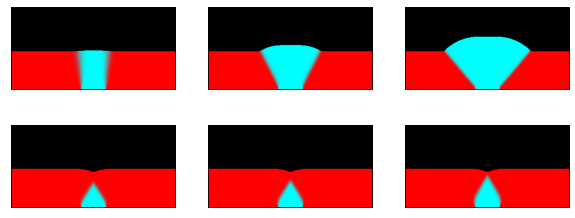

In [8]:
fig, ax = plt.subplots( 2,3, figsize=(10,4) );

for i in np.arange(2):
    for j in np.arange(3):
        img = np.copy(imgs[i*2,j]);
        img = img.swapaxes(0,1);
        img = np.flip(img,axis=0);
        img = img[200:]
        ax[i,j].imshow(img)
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
        
#fig.savefig('s6.pdf',bbox_inches='tight')

## cheater-cooperator model simulation (model 3)

In [14]:
L=400;
N0 = np.zeros((2,L,L)); # type, x, y
N0[0,:int(L/2)-30,:3]+=1; N0[0,int(L/2)+30:,:3]+=1;
N0[1,int(L/2)-30:int(L/2)+30,:3]+=1; 

us = np.zeros((3,3));
for i in np.arange(3):
    us[i] = np.array([0.2,0.6,1.]);
vms = np.zeros((3,3));
vms[0] = np.sqrt(1+us[0]**2);
vms[1] = 1+(vms[0]-1)/2;
vms[2] += 0.8;
ss = 1-vms**2;
alphas = ss+us**2;

imgs = np.zeros((3,3,L,L,3));
for i in tqdm(np.arange(3)):
    for j in np.arange(3):
        if( (i,j)==(1,0) ): continue;
        test = Sim2D(L=L, Tmax=10000, N0=N0, model=3 );
        test.generate_step([1,1,ss[i,j],-alphas[i,j],alphas[i,j]]);
        test.proceed();
        a=analysis(test);        
        img = a.snapsave(-2);
        img[:,:,2] = img[:,:,1];
        img[:,:,1] = img[:,:,1];
        imgs[i,j] = img;
#np.savez('sim_model3.npz', imgs=imgs);

  0%|          | 0/3 [00:00<?, ?it/s]/state/partition1/llgrid/pkg/anaconda/anaconda3-2020b/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020b/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020b/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 3/3 [17:05<00:00, 341.82s/it]


## growth-dispersal tradeoff model simulation (model 0)

In [30]:
L=400;
N0 = np.zeros((2,L,L)); # type, x, y
N0[0,:int(L/2)-30,:3]+=1; N0[0,int(L/2)+30:,:3]+=1;
N0[1,int(L/2)-30:int(L/2)+30,:3]+=1; 

us = np.zeros((3,3));
for i in np.arange(3):
    us[i] = np.array([0.2,0.6,1.]);
vms = np.zeros((3,3));
vms[0] = np.sqrt(1+us[0]**2);
vms[1] = 1+(vms[0]-1)/2;
vms[2] += 0.8;
ss = us**2;
d1s = 1- vms**2/(1+ss);

imgs = np.zeros((3,3,L,L,3));
for i in tqdm(np.arange(3)):
    for j in np.arange(3):
        if( (i,j)==(1,0) ): continue;
        test = Sim2D(L=L, Tmax=501, N0=N0, model=4 );
        test.generate_step([1,1,d1s[i,j], ss[i,j]]);
        test.proceed();
        a=analysis(test);        
        img = a.snapsave(-2);
        img[:,:,2] = img[:,:,1];
        img[:,:,1] = img[:,:,1];
        imgs[i,j] = img;
#np.savez('sim_model4.npz', imgs=imgs);

  0%|          | 0/3 [00:00<?, ?it/s]/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 3/3 [00:49<00:00, 17.37s/it]


## Density-independent dispersal and growth model simulation

In [17]:
L=400;
N0 = np.zeros((2,L,L)); # type, x, y
N0[0,:int(L/2)-30,:3]+=1; N0[0,int(L/2)+30:,:3]+=1;
N0[1,int(L/2)-30:int(L/2)+30,:3]+=1; 

ss = np.array([0.1, 0.4, 0.9]);
D1s = np.zeros((3,4));
D1s[:,0] = 1 - 1/(1+ss);
D1s[:,1] = np.zeros(3);
D1s[:,2] = [0, 0.149, 0.255];
D1s[:,3] = 1 - (0.75**2)/(1+ss)

imgs = np.zeros((3,4,L,L,3));
for i in tqdm(np.arange(3)):
    for j in np.arange(4):
        test = Sim2D(L=L, Tmax=10000, N0=N0, model=4 );
        test.generate_step([1,1,D1s[i,j],ss[i]]);
        test.proceed();
        a=analysis(test);        
        img = a.snapsave(4);
        img[:,:,2] = img[:,:,1];
        img[:,:,1] = img[:,:,1];
        imgs[i,j] = img;
#np.savez('sim_model0.npz', imgs=imgs);

  0%|          | 0/3 [00:00<?, ?it/s]/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide
/state/partition1/llgrid/pkg/anaconda/anaconda3-2020a/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 3/3 [14:14<00:00, 305.75s/it]
